# PROCESADO DE IMAGENES

## 1. Cargar librerías


Cargamos archivo de imagen

NOTA: Tener en cuenta que para mostrar los frames hay que transformarlos de bgr a rgb


In [18]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from line import Line
from processor import ImageProcessor
from tracker import Tracker

# Config camara raspberry en /dev/video0
camera = cv2.VideoCapture('/dev/video0', cv2.CAP_V4L)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
processor = ImageProcessor((640, 480), 20)

# Define the average positions for the left and right lanes.
averageLeft = np.poly1d(np.array([-0.3756, 292.7]))
averageRight = np.poly1d(np.array([0.4277, 348.6]))
rutas_imagenes = [
        "/home/lab/robocar/pruebas/computer_vision/SelfDrivingVehicle/tracking/frame_1.jpg",
        "/home/lab/robocar/pruebas/computer_vision/SelfDrivingVehicle/tracking/frame_2.jpg",
        "/home/lab/robocar/pruebas/computer_vision/SelfDrivingVehicle/tracking/frame_3.jpg",
        "/home/lab/robocar/pruebas/computer_vision/SelfDrivingVehicle/tracking/frame_4.jpg",
        "/home/lab/robocar/pruebas/computer_vision/SelfDrivingVehicle/tracking/frame_5.jpg",
    ]

## RECOGER FRAMES

In [ ]:
respuesta = input('Estas seguro de que quieres leer frames?(y/n) ')

if respuesta.lower() != 'y':
    print("Cancelado.")
else: 
    for ruta in rutas_imagenes:
        # Leer un frame
        ret, frame = camera.read()
        if not ret:
            print("Error al capturar el frame. Saliendo...")
            break
        
        # Convertir BGR a RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Mostrar el frame con matplotlib
        plt.imshow(frame_rgb)
        plt.title("Frame Capturado")
        plt.show()
        
        # Guardar el frame
        cv2.imwrite(ruta, frame)
        input('leyendo... Pulsar tecla')
        # Lee y descarta un número determinado de frames para limpiar el buffer
        for _ in range(50):  # Ajusta el número de frames a descartar según sea necesario
            ret, frame = camera.read()

    # Liberar la cámara y cerrar todas las ventanas
    camera.release()
    cv2.destroyAllWindows()

In [25]:
# Cargar imagenes: 
frames_array = []
for ruta in rutas_imagenes:
    frame = cv2.imread(ruta)
    frames_array.append(frame)

IMAGEN BINARIA:

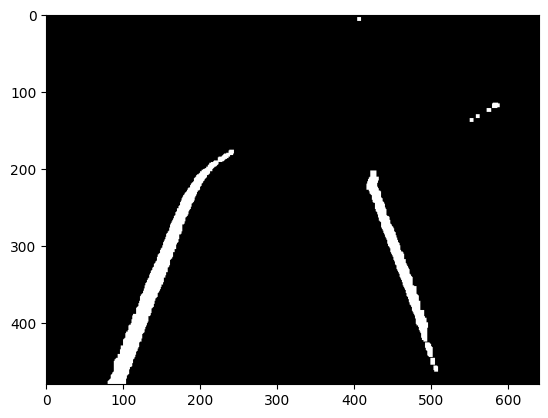

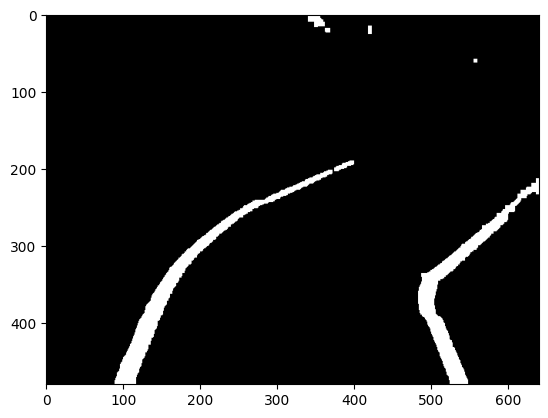

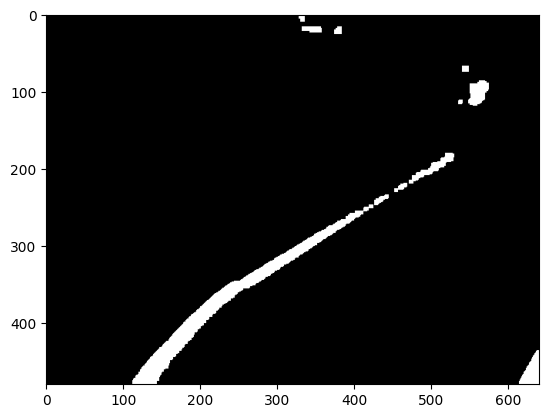

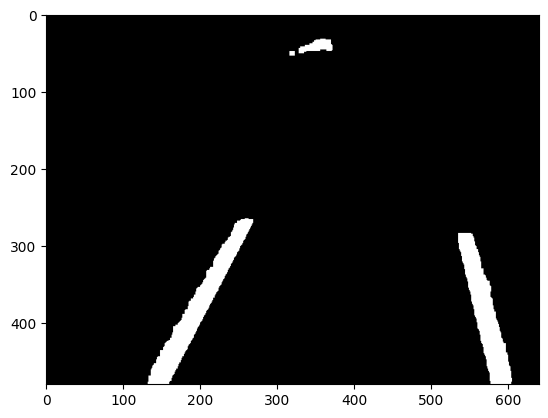

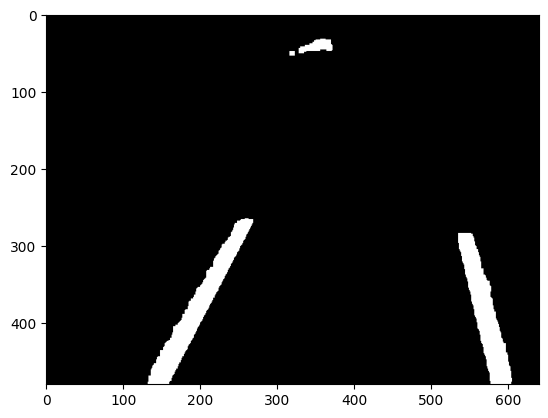

In [20]:
binary_frames = []
for frame in frames_array:
    # Define the average positions for the left and right lanes.
    averageLeft = np.poly1d(np.array([-0.3756, 292.7]))
    averageRight = np.poly1d(np.array([0.4277, 348.6]))
    #out = processor.process(frame_rgb)
    # Convertir la imagen a HSV
    imagen_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Definir los valores de HSV para la detección del color rojo
    lower_hsv = np.array([130, 55, 0])
    upper_hsv = np.array([179, 255, 255])

    # Aplicar las máscaras HSV a la imagen
    mask = cv2.inRange(imagen_hsv, lower_hsv, upper_hsv)

    # Convertir la máscara a una imagen binaria 
    imagen_binaria = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]

    # Definir el kernel para las operaciones morfológicas
    kernel = np.ones((5,5), np.uint8)  # Puedes ajustar el tamaño del kernel según tus necesidades

    # Aplicar cierre morfológico para eliminar líneas finas
    cierre = cv2.morphologyEx(imagen_binaria, cv2.MORPH_CLOSE, kernel)

    # (Opcional) Aplicar apertura morfológica para limpiar ruido restante
    binary = cv2.morphologyEx(cierre, cv2.MORPH_OPEN, kernel)
    binary_frames.append(binary)

    plt.imshow(binary, cmap='gray')
    plt.show()

Canny:

threshold1 (Umbral Inferior): Este es el valor mínimo de gradiente de intensidad para que un punto sea considerado como un borde. Cualquier cambio en la intensidad por debajo de este valor no se considera como un borde.

threshold2 (Umbral Superior): Este es el valor máximo de gradiente de intensidad para que un punto sea considerado como un borde. Cualquier cambio en la intensidad por encima de este valor se considera definitivamente como un borde.

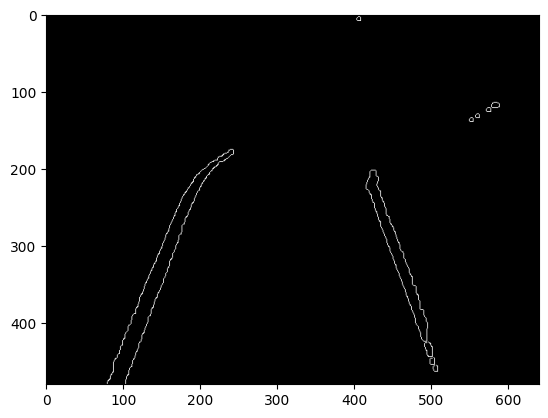

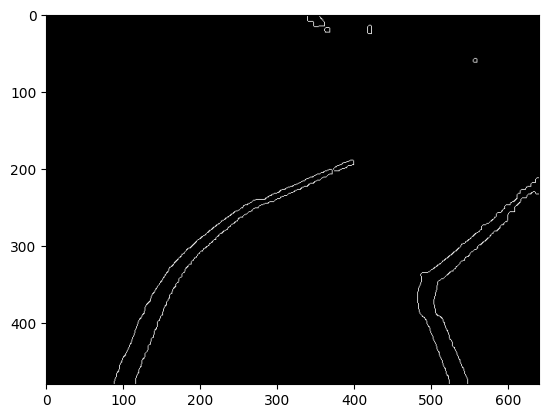

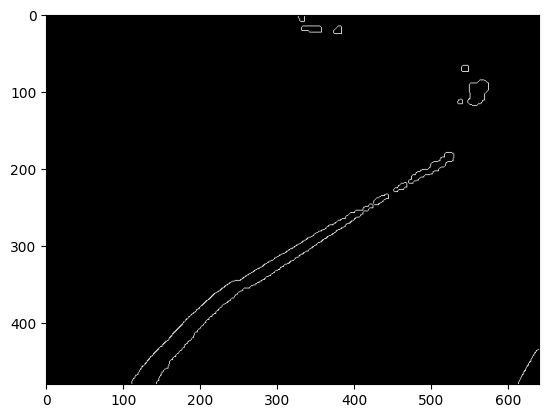

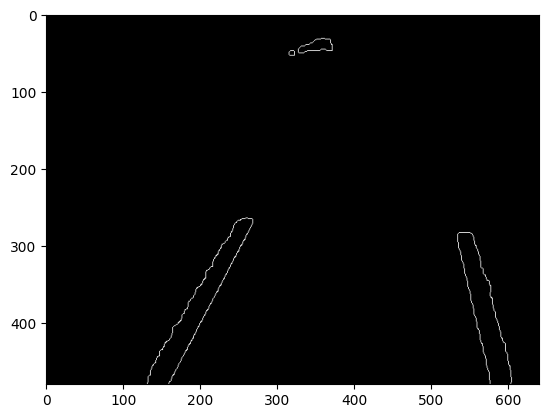

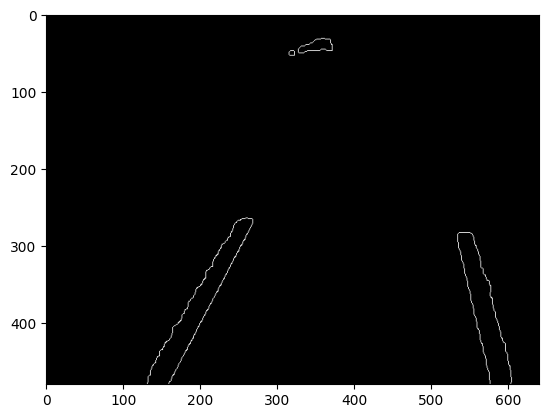

In [21]:
for binary in binary_frames:
    canny = cv2.Canny(binary, threshold1=20, threshold2=40)
    plt.imshow(canny, cmap='gray')
    plt.show()

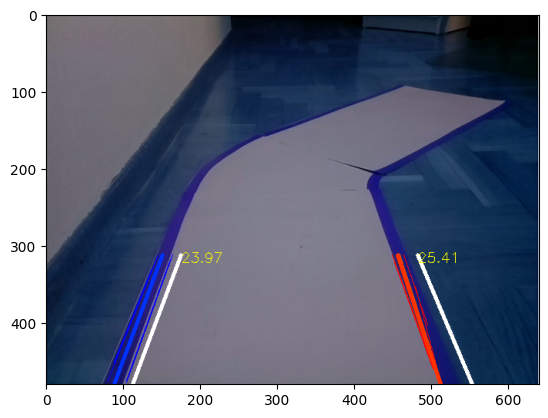

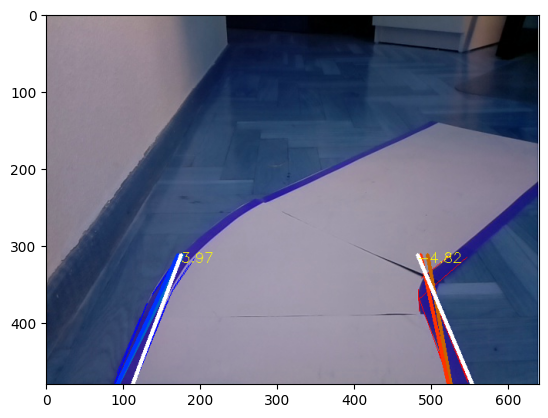

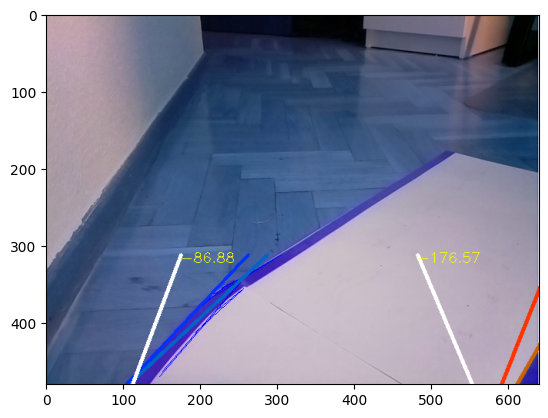

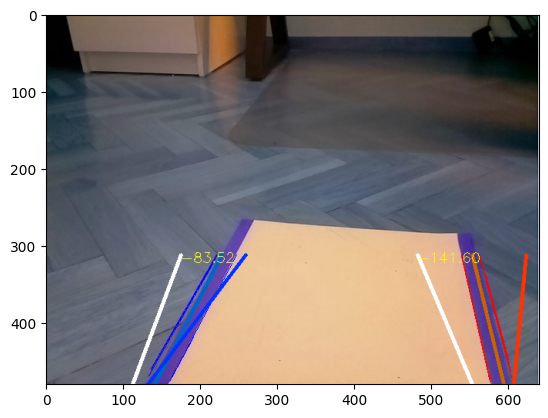

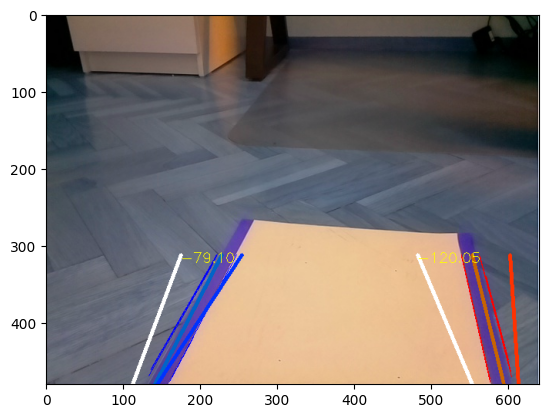

In [26]:
rightTracker = Tracker()
leftTracker = Tracker()
processed_frames = []
left_lanes = []
right_lanes = []

for frame in frames_array:
    processed_frame = processor.process(frame)
    processed_frames.append(processed_frame)

    left = leftTracker.add(processor.left.poly)
    right = rightTracker.add(processor.right.poly)

    left_lanes.append(left)
    right_lanes.append(right)

    # 4. Draws the unfiltered lanes.
    processor.drawPoly(processed_frame, processor.left.poly, (0, 100, 200))
    processor.drawPoly(processed_frame, processor.right.poly, (200, 100, 0))

    # 4. Draws the output of the Kalman Filter.
    processor.drawPoly(processed_frame, left, (0, 50, 255))
    processor.drawPoly(processed_frame, right, (255, 50, 0))

    # 4. Draws the average position for the lanes.
    processor.drawPoly(processed_frame, averageLeft, (255, 255, 255))
    processor.drawPoly(processed_frame, averageRight, (255, 255, 255))

    # Calculates the error on both lanes.
    y0 = processor.roiY[1] * processor.h
    leftError = averageLeft(y0) - left(y0)
    rightError = averageRight(y0) - right(y0)
    averageError = (leftError + rightError) / 2

    # Displays the error on the frame.
    cv2.putText(processed_frame, '%.2f' % (leftError), (int(averageLeft(y0)), int(y0) + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1)
    cv2.putText(processed_frame, '%.2f' % (rightError), (int(averageRight(y0)), int(y0) + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1)

    plt.imshow(processed_frame)
    plt.show()

In [ ]:
roi = processor.doRegionOfInterest(frame_rgb)
plt.imshow(roi)
plt.show()

In [ ]:
for frame in processed_frames:
    # 3. Passes the found lanes to the Kalman Filter.
    rightTracker = Tracker()
    leftTracker = Tracker()
    left = leftTracker.add(processor.left.poly)
    right = rightTracker.add(processor.right.poly)

    print('Coeficientes de left: ', left)
    print('Coeficientes de right: ', right)

    # 4. Draws the unfiltered lanes.
    processor.drawPoly(processed_frame, left, (0, 100, 200))
    processor.drawPoly(processed_frame, right, (0, 255, 255))

    plt.imshow(processed_frame)
    plt.show()

In [ ]:
# Calculates the error on both lanes.
y0 = processor.roiY[0] * processor.h
leftError = averageLeft(y0) - left(y0)
rightError = averageRight(y0) - right(y0)
averageError = (leftError + rightError) / 2

cv2.putText(processed_frame, '%.2f' % (leftError), (int(averageLeft(y0)), int(y0) - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(processed_frame, '%.2f' % (rightError), (int(averageRight(y0)), int(y0) - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
plt.imshow(processed_frame)
plt.show()

In [ ]:
# 4. Draws the output of the Kalman Filter.
processor.drawPoly(processed_frame, left, (0, 50, 255))
processor.drawPoly(processed_frame, right, (0, 255, 0))
plt.imshow(processed_frame)
plt.show()

In [ ]:
processor.drawPoly(frame_rgb, averageLeft, (255, 255, 255))
processor.drawPoly(frame_rgb, averageRight, (255, 255, 255))

plt.imshow(frame_rgb)
plt.show()

In [ ]:
processed_curva = processor.process(frame_curva)
plt.imshow(processed_curva)
plt.show()

In [ ]:
left_curva = leftTracker.add(processor.left.poly)
right_curva = rightTracker.add(processor.right.poly)

print('Coeficientes de left: ', left)
print('Coeficientes de right: ', right)


# 4. Draws the unfiltered lanes.
processor.drawPoly(frame_curva, averageLeft, (255, 255, 255))
processor.drawPoly(frame_curva, averageRight, (255, 255, 255))
processor.drawPoly(frame_curva, left_curva, (0, 100, 200))
processor.drawPoly(frame_curva, right_curva, (0, 255, 255))
plt.imshow(frame_curva)
plt.show()

In [ ]:
# Calculates the error on both lanes.
y0 = processor.roiY[0] * processor.h
leftError_curva = averageLeft(y0) - left_curva(y0)
rightError_curva = averageRight(y0) - right_curva(y0)
averageError_curva = (leftError_curva + rightError_curva) / 2

cv2.putText(frame_curva, '%.2f' % (leftError_curva), (int(averageLeft(y0)), int(y0) - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(frame_curva, '%.2f' % (rightError_curva), (int(averageRight(y0)), int(y0) - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
plt.imshow(frame_curva)
plt.show()

In [ ]:
# calcular angulo de giro en funcion del offset:
# si el offset es positivo, el coche debe girar a la derecha
# si el offset es negativo, el coche debe girar a la izquierda
# si el offset es 0, el coche debe ir recto

proporcion_error_angulo = 0.5  # Grados de giro por unidad de error

# Calcula el ángulo de giro necesario basado en el error promedio
angulo_giro = averageError_curva * proporcion_error_angulo

# Ajusta el ángulo de giro según la dirección del error
# Si el error es positivo, el coche está a la derecha de donde debería estar, por lo que giramos hacia la izquierda (y viceversa).
# Nota: Este ajuste depende de cómo definas la dirección positiva/negativa en tu sistema.

print(f"Ángulo de giro necesario: {angulo_giro} grados")


In [ ]:
processed_nada = processor.process(frame_nada)
plt.imshow(processed_nada)
plt.show()

In [ ]:
left_nada = leftTracker.add(processor.left.poly)
right_nada = rightTracker.add(processor.right.poly)

print('Coeficientes de left: ', left_nada)
print('Coeficientes de right: ', right_nada)


# 4. Draws the unfiltered lanes.
processor.drawPoly(frame_nada, left_nada, (0, 100, 200))
processor.drawPoly(frame_nada, right_nada, (0, 255, 255))
plt.imshow(frame_nada)
plt.show()